In [1]:
import scanpy as sc

In [2]:
import pandas as pd
import numpy as np
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [3]:
import os

In [4]:
import matplotlib.pyplot as plt

In [5]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

### Prepare sc data

In [6]:
adata = sc.read('zenodo/breast_tumor.h5ad')

In [8]:
adata.obs['label'] = adata.obs['level2_cell_type']

In [9]:
adata.obs['replicate'] = adata.obs['dataset']

In [10]:
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["replicate"], adata.obs["label"])
]

In [11]:
adata.obs["replicate"] = adata.obs["replicate"].astype("category")
adata.obs["label"] = adata.obs["label"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")

In [12]:
del adata.obsp
del adata.uns
adata.obsm.pop('X_scANVI')
adata.obsm.pop('X_scVI')

array([[ 0.34304455, -0.8480481 , -2.1054945 , ...,  1.4949648 ,
         0.783535  , -0.13358653],
       [-0.40858796, -1.244035  , -0.55277884, ..., -0.06494236,
         0.2370826 ,  0.36601478],
       [-0.38083577, -0.85870117, -1.5794281 , ...,  1.0033696 ,
         0.30317986, -1.0668485 ],
       ...,
       [-0.8336443 , -1.3808289 , -0.93913925, ...,  0.4861822 ,
         0.751075  , -0.9916712 ],
       [ 1.0239079 , -1.2588183 ,  0.24950886, ...,  1.758765  ,
         1.2001036 ,  0.04110301],
       [ 1.1117136 , -1.196759  , -0.34465873, ...,  1.604173  ,
         1.7888407 ,  0.35298032]], dtype=float32)

In [13]:
adata.obs['cellstate'] = adata.obs['label']

In [14]:
cellstate_celltype_dict = {'B cells' : 'B cells', 'CD56bright NK cells' : 'NK cells', 'CD56dim NK cells' : 'NK cells', 'Dendritic cells' : 'Myeloid',
       'Endothelial cells' : 'Endothelial cells', 'Fibroblasts' : 'Fibroblasts', 'ILCs' : 'ILCs', 'MAIT cells' : 'T cells', 'Macrophages' : 'Myeloid',
       'Melanoma cells' : 'Melanoma cells', 'Memory B cells' : 'B cells', 'Monocytes' : 'Myeloid', 'Regulatory T cells' : 'T cells',
       'Tcm/Naive helper T cells' : 'T cells', 'Tem/Effector helper T cells' : 'T cells',
       'Tem/Trm cytotoxic T cells' : 'T cells', 'Type 1 helper T cells' : 'T cells', 'CAFs' : 'CAFs', 'Late erythroid' : 'Late erythroid', 'Cancer Basal SC' : 'Tumor',
       'Cancer Cycling' : 'Tumor', 'Cancer LumA SC' : 'Tumor', 'Luminal Progenitors' : 'Epithelial cells', 'Mast cells' : 'Myeloid', 'Mature Luminal' : 'Epithelial cells',
       'Myoepithelial' : 'Epithelial cells', 'NKT cells' : 'NKT cells', 'PVL Differentiated' : 'PVL differentiated', 'Plasma cells' : 'B cells'}

In [15]:
adata.obs['celltype'] = [cellstate_celltype_dict[x] for x in adata.obs['cellstate']]

In [16]:
adata_subsample = sc.pp.subsample(adata, fraction=0.2, copy=True)

In [17]:
%%R -i adata_subsample
adata_subsample

class: SingleCellExperiment 
dim: 15298 89075 
metadata(0):
assays(1): X
rownames(15298): C1orf122 COX4I1 ... IZUMO2 FAT2
rowData names(0):
colnames(89075): CID3586_GATCAGTAGTACGCGA_CID3586_CID3586
  TCACGAAAGGCAGTCA-1_GSM4909285_TN-B1-MH4031_GSM4909285_TN-B1-MH4031
  ... CID4066_GTCGTAAGTATAGGGC_CID4066_CID4066
  CID4290A_TGCCCATTCAGGTTCA_CID4290A_CID4290A
colData names(21): sample patient ... cellstate celltype
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):


In [18]:
%%R
sc.dat <- t(assay(adata_subsample))

In [19]:
%%R
sc.dat <- as.matrix(sc.dat)

In [20]:
%%R
cell.type.labels <- colData(adata_subsample)$celltype

In [21]:
%%R
cell.type.labels <- as.vector(cell.type.labels)

In [22]:
%%R
cell.state.labels <- colData(adata_subsample)$cellstate

In [23]:
%%R
cell.state.labels <- as.vector(cell.state.labels)

### download and prepare tcga data

In [7]:
%%R
library(TCGAbiolinks)

In [8]:
%%R
library(scran)

In [26]:
%%R
my.dir = '/tumor-data/GDCdata'

# Gene expression aligned against hg38
query <- GDCquery(
    project = "TCGA-BRCA",
    data.category = "Transcriptome Profiling",
    data.type = "Gene Expression Quantification", 
    workflow.type = "STAR - Counts"
)
#GDCdownload(query = query,
#            directory = my.dir)

data <- GDCprepare(query = query,
                   directory = my.dir,
                   save = TRUE,
                   save.filename = "/tumor-data/BRCA_exp.rda")

|====================================================|100% ~0 s remainingininggg                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [27]:
%%R
bk.mtx <- assay(data)

In [28]:
%%R
rownames(bk.mtx) <- rowData(data)$gene_name

In [29]:
%%R
bk.dat <- t(bk.mtx)

In [9]:
%%R
clin.dat <- GDCquery_clinic("TCGA-BRCA", "clinical")

In [31]:
%%R
colnames(bk.dat) <- make.unique(colnames(bk.dat), sep = ".")

In [32]:
%%R
dim(bk.dat)

[1]  1231 60660


### BayesPrism

In [33]:
%%R
library(BayesPrism)

In [34]:
%%R
sc.dat.filtered <- cleanup.genes (input=sc.dat, input.type="count.matrix",
                                  species="hs",
                                  gene.group=c( "Rb","Mrp","other_Rb","chrM","MALAT1","chrX","chrY") , exp.cells=5)

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.
number of genes filtered in each category: 
      Rb      Mrp other_Rb     chrM   MALAT1     chrX     chrY 
      85       78       14       13        1      533       17 
A total of  709  genes from Rb Mrp other_Rb chrM MALAT1 chrX chrY  have been excluded 
A total of  1  gene expressed in fewer than  5  cells have been excluded 


In [35]:
%%R
dim(sc.dat.filtered)

[1] 89075 14588


In [36]:
%%R
myPrism <- new.prism(reference=sc.dat.filtered,
                     mixture=bk.dat,
                     input.type="count.matrix",
                     cell.type.labels = cell.type.labels,
                     cell.state.labels = cell.state.labels,
                     key='Tumor',
                     outlier.cut=0.01,
                     outlier.fraction=0.1,
)

number of cells in each cell state 
cell.state.labels
                       ILCs              Late erythroid 
                        106                         127 
                  Monocytes                  Mast cells 
                        241                         262 
                  NKT cells            CD56dim NK cells 
                        271                         291 
              Myoepithelial         CD56bright NK cells 
                        673                         795 
                    B cells             Dendritic cells 
                        817                         922 
        Luminal Progenitors          PVL Differentiated 
                       1334                        2028 
             Mature Luminal Tem/Effector helper T cells 
                       2154                        2651 
          Endothelial cells              Memory B cells 
                       2801                        2854 
               Plasma cells    Tcm

In [37]:
%%R
bp.res <- run.prism(prism = myPrism, n.cores=5)

Run Gibbs sampling... 
Current time:  2023-11-23 16:54:47 
Estimated time to complete:  21hrs 20mins 
Estimated finishing time:  2023-11-24 14:14:34 
Start run... 
R Version:  R version 4.2.3 (2023-03-15) 

Update the reference matrix ... 
Run Gibbs sampling using updated reference ... 
Current time:  2023-11-23 23:23:16 
Estimated time to complete:  10hrs 26mins 
Estimated finishing time:  2023-11-24 09:48:20 
Start run... 


In [11]:
%%R -o Z_nk,Z_nk_colnames,Z_nk_rownames
Z_nk <- get.exp(bp.res, state.or.type='type', cell.name='NK cells')
Z_nk_colnames <- colnames(Z_nk)
Z_nk_rownames <- rownames(Z_nk)

In [12]:
Z_nk = pd.DataFrame(Z_nk,index=Z_nk_rownames,columns=Z_nk_colnames) ### NK expression matrix (patients x genes)

In [13]:
Z_nk_adata = sc.AnnData(Z_nk)

In [14]:
Z_nk_adata

AnnData object with n_obs × n_vars = 1231 × 14262

In [15]:
%%R -o theta,theta_colnames,theta_rownames
theta <- get.fraction(bp=bp.res, 
                       which.theta="final",
                       state.or.type="type")

theta_colnames <- colnames(theta)
theta_rownames <- rownames(theta)

In [16]:
%%R -o theta_state,theta_state_colnames,theta_state_rownames
theta_state <- get.fraction(bp=bp.res, 
                       which.theta="first",
                       state.or.type="state")

theta_state_colnames <- colnames(theta_state)
theta_state_rownames <- rownames(theta_state)

In [17]:
theta_type_df = pd.DataFrame(theta,index=theta_rownames,columns=theta_colnames) ### Cell type fractions (patients x cell types)

In [18]:
theta_state_df = pd.DataFrame(theta_state,index=theta_state_rownames,columns=theta_state_colnames) ### Cell state fractions (patients x cell states)

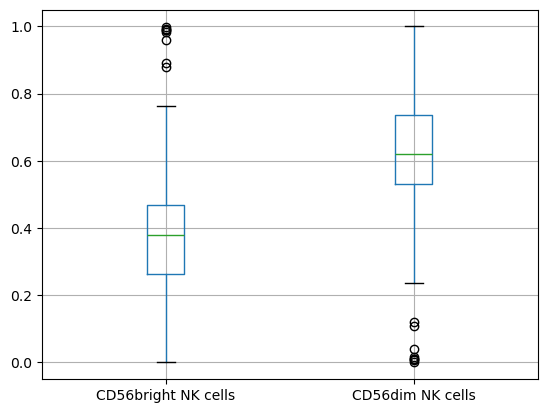

In [19]:
bp_plot = pd.DataFrame(theta_state_df[['CD56bright NK cells', 'CD56dim NK cells']].T/theta_state_df[['CD56bright NK cells', 'CD56dim NK cells']].sum(axis=1).T).T.boxplot()

In [20]:
figure = bp_plot.get_figure()    
figure.savefig('cd56bright_cd56dim_breast_tcga.pdf', dpi=400)

In [21]:
theta_state_groups = theta_state_df[['CD56bright NK cells', 'CD56dim NK cells']].copy()

In [25]:
theta_type_immune = theta_type_df[['T cells', 'Myeloid', 'B cells', 'NK cells', 'ILC']].copy()

In [26]:
theta_type_immune.index = ['-'.join(x.split('-')[:3]) for x in theta_type_immune.index]

In [27]:
theta_type_immune = theta_type_immune[~theta_type_immune.index.duplicated(keep='first')]

In [28]:
theta_state_groups.index = ['-'.join(x.split('-')[:3]) for x in theta_state_groups.index]

In [29]:
theta_state_groups = theta_state_groups[~theta_state_groups.index.duplicated(keep='first')]

In [30]:
theta_state_groups_fraction = (theta_state_groups.T/theta_state_groups.sum(axis=1)).T.copy()

In [31]:
theta_type_immune_fraction = (theta_type_immune.T/theta_type_immune.sum(axis=1)).T.copy()

#### Clinical BRCA

In [32]:
%%R -o clin_brca
clin_brca <- clin.dat

In [33]:
brca_survival_df = pd.read_csv('/tumor-data/survival%2FBRCA_survival.txt', sep='\t')

In [34]:
brca_survival_df = brca_survival_df.drop_duplicates(subset='_PATIENT')

In [35]:
clin_brca = clin_brca[[x in theta_type_immune.index for x in clin_brca['submitter_id']]]

In [36]:
brca_survival_df.index = brca_survival_df['_PATIENT']

In [37]:
clin_brca = clin_brca[[x in brca_survival_df.index for x in clin_brca['submitter_id']]]

In [38]:
brca_survival_df = brca_survival_df.loc[clin_brca['submitter_id']].copy()

In [39]:
clin_brca.loc[:,brca_survival_df.columns] = brca_survival_df.values

/tmp/ipykernel_604772/874731392.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clin_brca.loc[:,brca_survival_df.columns] = brca_survival_df.values


In [40]:
clin_brca['total_nk'] = ['high' if x in theta_type_immune.sort_values('NK cells')[-int(theta_type_immune.shape[0]/3):].index 
                        else 'low' if x in theta_type_immune.sort_values('NK cells')[:int(theta_type_immune.shape[0]/3)].index else 'middle' for x in clin_brca['submitter_id']]

In [41]:
cell_state='CD56bright NK cells'
clin_brca['cd56bright'] = ['high' if x in theta_state_groups.sort_values(cell_state)[-int(theta_state_groups.shape[0]/3):].index 
                                          else 'low' if x in theta_state_groups.sort_values(cell_state)[:int(theta_state_groups.shape[0]/3)].index else 'middle' for x in clin_brca['submitter_id']]

In [42]:
cell_state='CD56dim NK cells'
clin_brca['cd56dim'] = ['high' if x in theta_state_groups.sort_values(cell_state)[-int(theta_state_groups.shape[0]/3):].index 
                                          else 'low' if x in theta_state_groups.sort_values(cell_state)[:int(theta_state_groups.shape[0]/3)].index else 'middle' for x in clin_brca['submitter_id']]

#### Stratify by NK, CD56bright and CD56dim

In [43]:
test_group='total_nk'

In [44]:
clin_brca_test = clin_brca[clin_brca[f'{test_group}'] != 'middle'].copy()

In [45]:
%%R
library(survival)
library("survminer")

In [46]:
%%R -i clin_brca_test
clin_brca_test$OS=as.numeric(clin_brca_test$OS)
clin_brca_test$OS.time=as.numeric(clin_brca_test$OS.time)

clin_brca_test$OS.time <- clin_brca_test$OS.time / 365

clin_brca_test$OS[clin_brca_test$OS.time>7] <- 0
clin_brca_test$OS.time[clin_brca_test$OS.time>7] <- 7

clin_brca_test$OS.use=clin_brca_test$OS
clin_brca_test$OS.time.use=clin_brca_test$OS.time

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Redaction". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


In [47]:
#%%R
#cox = coxph(Surv(OS.time.use,OS.use) ~ g1 + gender + age_at_index + ajcc_pathologic_stage, data=clin_brca_test)

In [48]:
%%R -i test_group
#form = as.formula(paste('Surv(OS.time.use,OS.use)', '~', test_group))
fit = survfit(as.formula(paste('Surv(OS.time.use,OS.use)', '~', test_group)), data=clin_brca_test)

In [49]:
%%R
dir=""
cancer=paste('BRCA', '_', test_group)
p = ggsurvplot(fit, clin_brca_test, size=0.3, vlegend.labs=unique(clin_brca_test[[test_group]]),
                   surv.median.line="none", pval=T, conf.int=F,
                   palette=c("#990066","#CCCCCC"),title=cancer) + 
                   xlab("Years")
    
pdf(file=sprintf("survival_%s.pdf", cancer), width=3, height=3,onefile = FALSE)
print(p)
dev.off()

png 
  2 


#### Score NK cell states

In [52]:
from pyscenic.aucell import aucell
from ctxcore.genesig import GeneSignature
from pyscenic.aucell import create_rankings, enrichment

In [54]:
all_groups_deg = pd.read_csv('nhood_markers_all.csv')

In [55]:
for group in range(1,7):
    all_groups_deg[f'rank_{group}'] = all_groups_deg[f'logFC_{group}']*-np.log10(all_groups_deg[f'adj.P.Val_{group}'])

In [56]:
group = 1
g1_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-30:]['GeneID'])

In [57]:
group = 2
g2_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-30:]['GeneID'])

In [58]:
group = 3
g3_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-30:]['GeneID'])

In [59]:
group = 4
g4_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-30:]['GeneID'])

In [60]:
group = 5
g5_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-30:]['GeneID'])

In [61]:
group = 6
g6_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-30:]['GeneID'])

In [62]:
signature_genes = [g1_sig,g2_sig,g3_sig,g4_sig,g5_sig,g6_sig]
signature_names = [f'g{x}' for x in range(1,7)]

In [63]:
gene_sigs = [GeneSignature(name,genes) for (name,genes) in zip(signature_names, signature_genes)]

In [64]:
exp_df = Z_nk_adata.to_df()#pd.DataFrame(adata.X.todense(), columns=adata.var.index, index=adata.obs.index)

In [65]:
import random

In [66]:
random.seed(0)

In [67]:
auc_mtx = aucell(exp_df, gene_sigs, num_workers=4)

In [68]:
auc_mtx.index = ['-'.join(x.split('-')[:3]) for x in auc_mtx.index]

In [69]:
auc_mtx = auc_mtx[~auc_mtx.index.duplicated(keep='first')]

In [70]:
auc_mtx = auc_mtx.loc[clin_brca['submitter_id']]

In [71]:
for i in range(1,7):
    nk_state=i
    clin_brca[f'g{nk_state}'] = ['high' if x in auc_mtx.sort_values(f'g{nk_state}')[-int(auc_mtx.shape[0]/2):].index 
                                else 'low' if x in auc_mtx.sort_values(f'g{nk_state}')[:int(auc_mtx.shape[0]/2)].index else 'middle' for x in clin_brca['submitter_id']]

In [72]:
clin_brca['g1g3'] = [f'{x[:2]}_{y[:2]}' for x,y in zip(clin_brca['g1'], clin_brca['g3'])]

In [73]:
clin_brca_test = clin_brca[clin_brca['g1g3'].isin(['lo_hi', 'hi_lo'])].copy()

In [74]:
%%R
library(survival)
library("survminer")

In [75]:
%%R -i clin_brca_test
clin_brca_test$OS=as.numeric(clin_brca_test$OS)
clin_brca_test$OS.time=as.numeric(clin_brca_test$OS.time)

clin_brca_test$OS.time <- clin_brca_test$OS.time / 365

clin_brca_test$OS[clin_brca_test$OS.time>7] <- 0
clin_brca_test$OS.time[clin_brca_test$OS.time>7] <- 7

clin_brca_test$OS.use=clin_brca_test$OS
clin_brca_test$OS.time.use=clin_brca_test$OS.time

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Redaction". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


In [76]:
#%%R
#cox = coxph(Surv(OS.time.use,OS.use) ~ g1 + gender + age_at_index + ajcc_pathologic_stage, data=clin_brca_test)

In [77]:
%%R
fit = survfit(Surv(OS.time.use,OS.use) ~ g1g3, data=clin_brca_test)

In [79]:
%%R
dir=""
cancer='BRCA_g1g3'
p = ggsurvplot(fit, clin_brca_test, size=0.3, vlegend.labs=unique(clin_brca_test$g1g3),
                   surv.median.line="none", pval=T, conf.int=F,
                   #risk.table=T, risk.table.y.text.col=T,
                   palette=c("#CCCCCC","#990066"),title=cancer) + 
                   xlab("Years")
    
pdf(file=sprintf("survival_%s.pdf", cancer), width=3, height=3,onefile = FALSE)
print(p)
dev.off()

png 
  2 
